In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('SEntFiN-v1.1.csv')

df = df[['Title', 'Decisions']]

df['Decisions'] = df['Decisions'].str.replace('"', '').str.strip()

print("Sample rows:")
print(df.head())

Sample rows:
                                               Title  \
0  SpiceJet to issue 6.4 crore warrants to promoters   
1                  MMTC Q2 net loss at Rs 10.4 crore   
2  Mid-cap funds can deliver more, stay put: Experts   
3             Mid caps now turn into market darlings   
4  Market seeing patience, if not conviction: Pra...   

                   Decisions  
0        {SpiceJet: neutral}  
1            {MMTC: neutral}  
2  {Mid-cap funds: positive}  
3       {Mid caps: positive}  
4          {Market: neutral}  


In [4]:
def encode_sentiment(sentiment):
    if sentiment == 'positive':
        return 1
    else:
        return 0

df['Sentiment'] = df['Decisions'].apply(encode_sentiment)

df = df[['Title', 'Sentiment']]

print("\nAfter encoding:")
print(df.head())



After encoding:
                                               Title  Sentiment
0  SpiceJet to issue 6.4 crore warrants to promoters          0
1                  MMTC Q2 net loss at Rs 10.4 crore          0
2  Mid-cap funds can deliver more, stay put: Experts          0
3             Mid caps now turn into market darlings          0
4  Market seeing patience, if not conviction: Pra...          0


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 30
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df['Title'])

sequences = tokenizer.texts_to_sequences(df['Title'])

padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(f"Padded shape: {padded.shape}")

Padded shape: (10753, 30)


In [6]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove.6B.zip

--2025-04-26 11:16:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-26 11:16:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-26 11:16:05--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [7]:
embedding_index = {}

with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

print(f"Found {len(embedding_index)} word vectors from GloVe.")

Found 400000 word vectors from GloVe.


In [8]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (10000, 100)


In [12]:
#Building CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=100,
              weights=[embedding_matrix],
              trainable=False),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, padded.shape[1]))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 30, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 26, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 22, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,154,497 (4.40 MB)

 Trainable params: 154,497 (603.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_val, y_train, y_val = train_test_split(
    padded,
    df['Sentiment'].values,
    test_size=0.2,
    stratify=df['Sentiment'].values,
    random_state=42
)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/20
269/269 - 7s - 25ms/step - accuracy: 0.9965 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 5.6030e-06
Epoch 2/20
269/269 - 6s - 24ms/step - accuracy: 1.0000 - loss: 2.5514e-05 - val_accuracy: 1.0000 - val_loss: 2.2989e-06
Epoch 3/20
269/269 - 8s - 30ms/step - accuracy: 1.0000 - loss: 1.6174e-05 - val_accuracy: 1.0000 - val_loss: 1.0883e-06
Epoch 4/20
269/269 - 7s - 25ms/step - accuracy: 1.0000 - loss: 1.3175e-05 - val_accuracy: 1.0000 - val_loss: 4.8881e-07
Epoch 5/20
269/269 - 4s - 16ms/step - accuracy: 1.0000 - loss: 5.4836e-06 - val_accuracy: 1.0000 - val_loss: 2.9048e-07
Epoch 6/20
269/269 - 7s - 26ms/step - accuracy: 1.0000 - loss: 1.1282e-06 - val_accuracy: 1.0000 - val_loss: 2.3773e-07
Epoch 7/20
269/269 - 4s - 17ms/step - accuracy: 1.0000 - loss: 2.3347e-06 - val_accuracy: 1.0000 - val_loss: 1.1981e-07
Epoch 8/20
269/269 - 5s - 19ms/step - accuracy: 1.0000 - loss: 1.6083e-06 - val_accuracy: 1.0000 - val_loss: 7.6288e-08
Epoch 9/20
269/269 - 6s - 23ms/step - accura

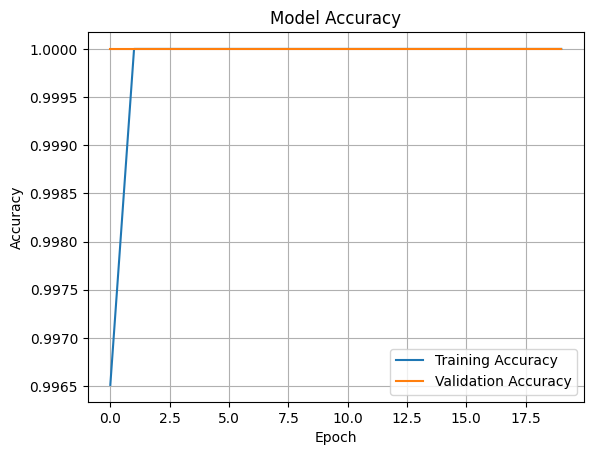

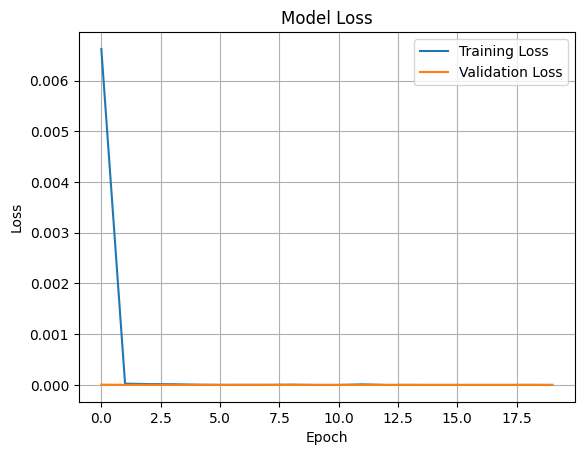

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


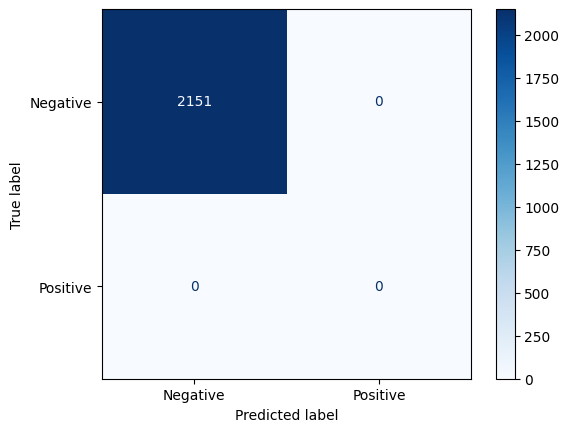


Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2151
    Positive       0.00      0.00      0.00         0

    accuracy                           1.00      2151
   macro avg       0.50      0.50      0.50      2151
weighted avg       1.00      1.00      1.00      2151



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_val, y_pred_classes, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes, target_names=["Negative", "Positive"], labels=[0,1]))

In [18]:
model.save('financial_news_sentiment_cnn_glove.h5')